# Notebook for feature extraction from the MOVIES

The features that we want to extract are:
- brightness
- contrast
- saturation
- sound strength
- music presence

The features are extracted from the movies using the following methods:
- **brightness**:
    1. Divide the video in frames using: https://www.geeksforgeeks.org/python-program-extract-frames-using-opencv/
    2. Convert the image to HSV color space (the Value channel is an approximation for brightness)
    3. Sum up all the values of the pixels in the Value channel
    4. Divide that brightness sum by the area of the image, which is just the width times the height.
    5. This gave us one value: the average brightness of that image per each time stamp.
- **contrast**:
    1. Same as brightness just with contrast
- **saturation**:
    1. Same as brightness just with saturation
- **sound strength**:
    1. Follow: https://towardsdatascience.com/generate-any-sport-highlights-using-python-3695c98baead

In [50]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import json
import re

In [16]:
# import default dictionary
from collections import defaultdict

def extract_annot(path_folder,film_ID):
    f = open (path_folder+'/Annot13_'+film_ID+'_stim.json', "r")
    data_annot = json.loads(f.read())
    annot = pd.read_csv(path_folder+'/Annot13_'+film_ID+'_stim.tsv', sep='\t', names=data_annot['Columns'])
    return annot

def extract_corrmat_allregressors(emo_path_folder,film_ID, individual='n', subject=None):
    annot=extract_annot(emo_path_folder, film_ID)
    corrmat_allregressors=np.corrcoef(annot.values)   
    return corrmat_allregressors

def extract_corrmat_emo(emo_path_folder,film_ID):
    positive_emotions = ['Love', 'Regard', 'WarmHeartedness', 'Pride','Satisfaction','Happiness']
    negative_emotions = ['Sad', 'Anxiety', 'Fear', 'Guilt','Disgust','Anger']
    all_emotions = positive_emotions + negative_emotions
    correlation_dict_positive = defaultdict(list)
    correlation_dict_negative = defaultdict(list)
    correlation_dict_all = defaultdict(list)
    #Extract the required data data from the emodata file
    annot=extract_annot(emo_path_folder,film_ID)
    positive_emotions_matrix = annot[positive_emotions].values
    negative_emotions_matrix = annot[negative_emotions].values
    all_emotions_matrix = annot[all_emotions].values
    #Compute correlation
    corrmat_positive=np.corrcoef(positive_emotions_matrix)   
    corrmat_negative=np.corrcoef(negative_emotions_matrix)   
    corrmat_all_emo=np.corrcoef(all_emotions_matrix)   
    return corrmat_positive, corrmat_negative, corrmat_all_emo

### **BRIGHTNESS**

1. Divide the video in frames using: https://www.geeksforgeeks.org/python-program-extract-frames-using-opencv/
2. Convert the image to HSV color space (the Value channel is an approximation for brightness)
3. Sum up all the values of the pixels in the Value channel
4. Divide that brightness sum by the area of the image, which is just the width times the height.
5. This gave us one value: the average brightness of that image per each time stamp.

In [5]:
PATH_MOVIES = '/Users/silviaromanato/Desktop/ServerMIPLAB/FilmFiles/'

for movie_name in os.listdir(PATH_MOVIES):
    MOVIE_PATH = PATH_MOVIES + movie_name
    break
MOVIE_PATH

OSError: [Errno 6] Device not configured: '/Users/silviaromanato/Desktop/ServerMIPLAB/FilmFiles/'

Extracting the frames from the first movie:

In [12]:
from PIL import Image
image = Image.open('/Users/silviaromanato/Library/Containers/com.apple.AMPArtworkAgent/Data/Documents/artwork/1ECCEA87E8F10B4A86FCA7FA6B0CBD9632C648E8C8A930C030EDC34CE88B6F8D_sk_13_cid_1.jpeg')

r_total = 0
g_total = 0
b_total = 0

image = image.convert('RGB')
width, height = image.size
for x in range(0, width):
    for y in range(0, height):
        r, g, b = image.getpixel((x, y))
        r_total += r
        g_total += g
        b_total += b

r_total = r_total / (width * height)
g_total = g_total / (width * height)
b_total = b_total / (width * height)







360000 360000


In [4]:
def convert_to_hsv(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    return h, s, v

average_brightness = []
average_saturation = []
def FrameCapture(MOVIE_PATH):
    # Path to video file
    vidObj = cv2.VideoCapture(MOVIE_PATH)

    count = 0
    success = 1

    while success:
        success, image = vidObj.read()
        print('The images is of shape: ', image.shape)

        # Convert to RGB
        image = image.convert('RGB')
        width, height = image.size
        for x in range(0, width):
            for y in range(0, height):
                r, g, b = image.getpixel((x, y))
                r_total += r
                g_total += g
                b_total += b

        r_total = r_total / (width * height)
        g_total = g_total / (width * height)
        b_total = b_total / (width * height)

        # Convert to HSV
        h_channel, s_channel, v_channel = convert_to_hsv(image)       
        sum_v = np.sum(v_channel)
        sum_s = np.sum(s_channel)
        sum_h = np.sum(h_channel)
        height, width = v_channel.shape[:2]
        total_pixels = width * height
        average_brightness.append(sum_v / total_pixels)
        average_saturation.append(sum_s / total_pixels)
        average_hue.append(sum_h / total_pixels)
        break


FrameCapture(MOVIE_PATH)

OpenCV: Couldn't read video stream from file "/Users/silviaromanato/Desktop/ServerMIPLAB/FilmFiles/You_Again_exp.mp4"


AttributeError: 'NoneType' object has no attribute 'shape'

### **SOUND STRENGTH**:
Follow: https://towardsdatascience.com/generate-any-sport-highlights-using-python-3695c98baead

In [2]:
!pip install moviepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 4.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.5/22.5 MB 7.1 MB/s eta 0:00:0000:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110730 sha256=7bdcdffc25f8ff15c3bc3fa313df05590a71187bd733424e18b58ba714e6a4c6
  Stored in directory: /Users/silviaromanato/Library/Caches/pip/wheels/29/15/e4/4f790bec6acd51a00b67e8ee1394f0bc6e0135c315f8ff399a
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipywidgets 8.0.5 requires jupyterlab-widgets~=3.0, which is not installed.
ipywidgets 8.0.5 requires widgetsnbextension~=4.0, wh

1. Extract the audio from the movie

In [ ]:
import moviepy.editor as mp
clip = mp.VideoFileClip(MOVIE_PATH).subclip(1, 1380)
clip.audio.write_audiofile("/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Audio/audioYouAgain.wav")

2. Create chunks from the audio

In [ ]:
import librosa
import IPython.display as ipd

filename = "filepath\\audio.wav"
# loading the file with a sampling rate
x, sr = librosa.load(filename, sr=22050)
# To get duration of the audio clip in minutes
int(librosa.get_duration(x, sr) / 60)
max_slice = 10
window_length = max_slice * sr
# Playing the audio chunk
a = x[21 * window_length:22 * window_length]
ipd.Audio(a, rate=sr)

3. Compute the short time energy of the chunk <br> <br>

The energy or power of an audio signal refers to the loudness of the sound. It is computed by the sum of the square of the amplitude of an audio signal in the time domain. When energy is computed for a chunk of an entire audio signal, then it is known as Short Time Energy.

In [ ]:
import numpy as np
s_energy = np.array([sum(abs(x[i:i + window_length] ** 2)) for i in range(0, len(x), window_length)])


import matplotlib.pyplot as plt
plt.hist(s_energy)
plt.show()

## **LOAD THE DATA EXTRACTED**

In [90]:
def Correlation_features(df_sound, df_brightness, movie_name): 

    ############### MERGE #################
    df_brightness.reset_index(drop=True, inplace=True)

    # concatenate the two dataframes
    if df_sound == None:
        df = df_brightness
    else:
        df_sound.reset_index(drop=True, inplace=True)
        df = pd.concat([df_sound, df_brightness], axis=1)
    df.reset_index(drop=True, inplace=True)

    ############### CORRELATION ################
    df = df.T
    corr_features = df.corr()
    corr_features.to_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/corr_{movie_name}_features.csv')

    return corr_features


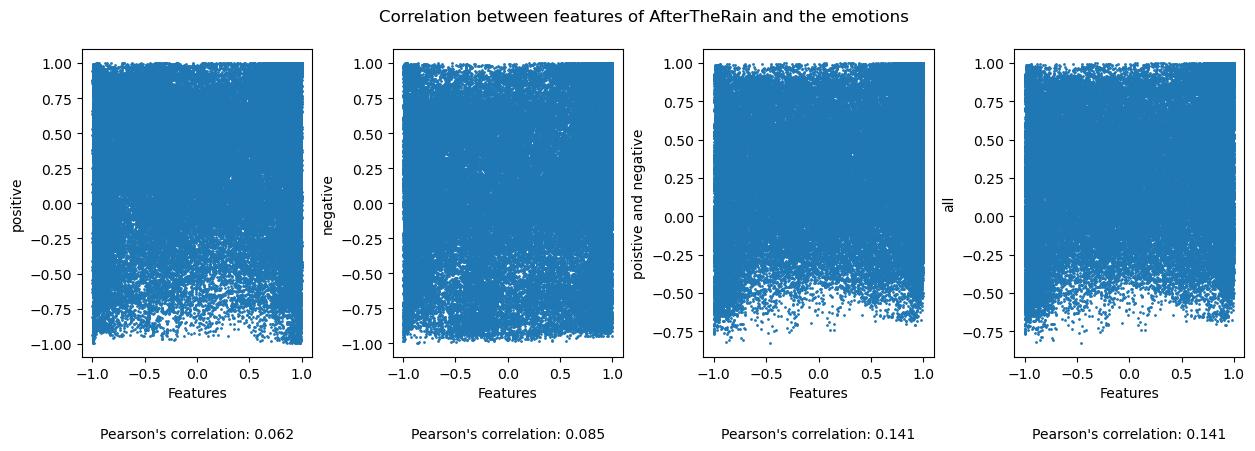

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


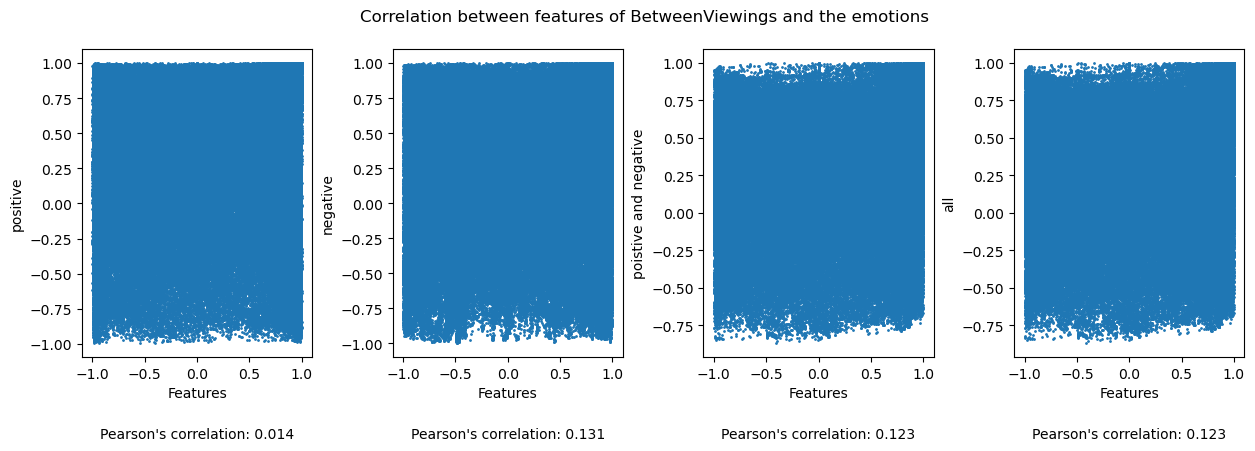

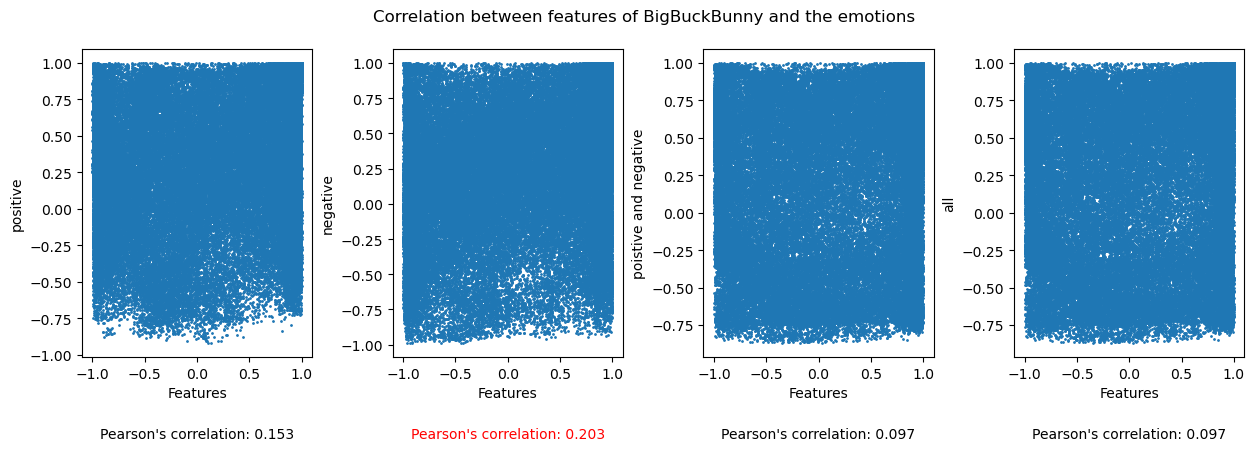

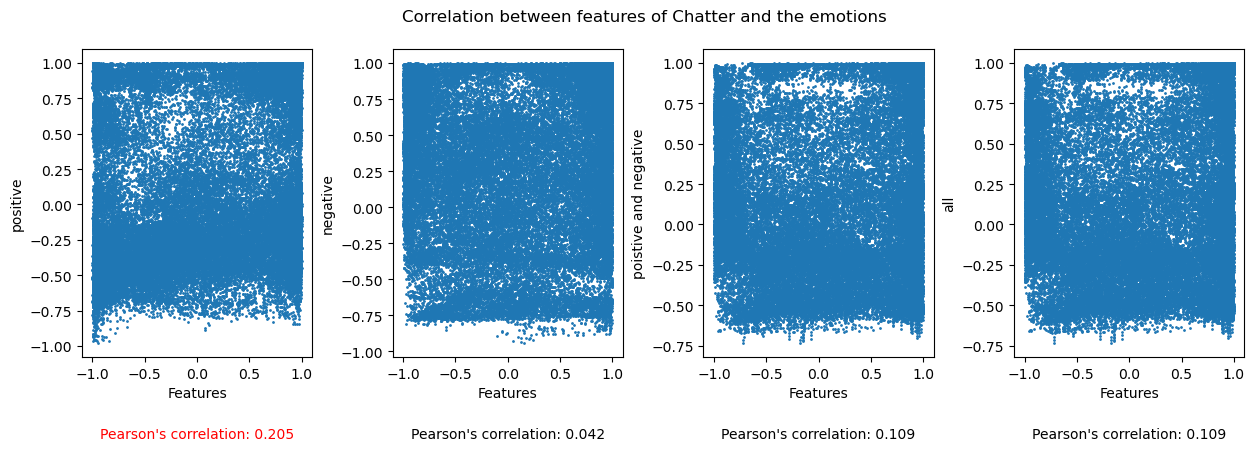

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


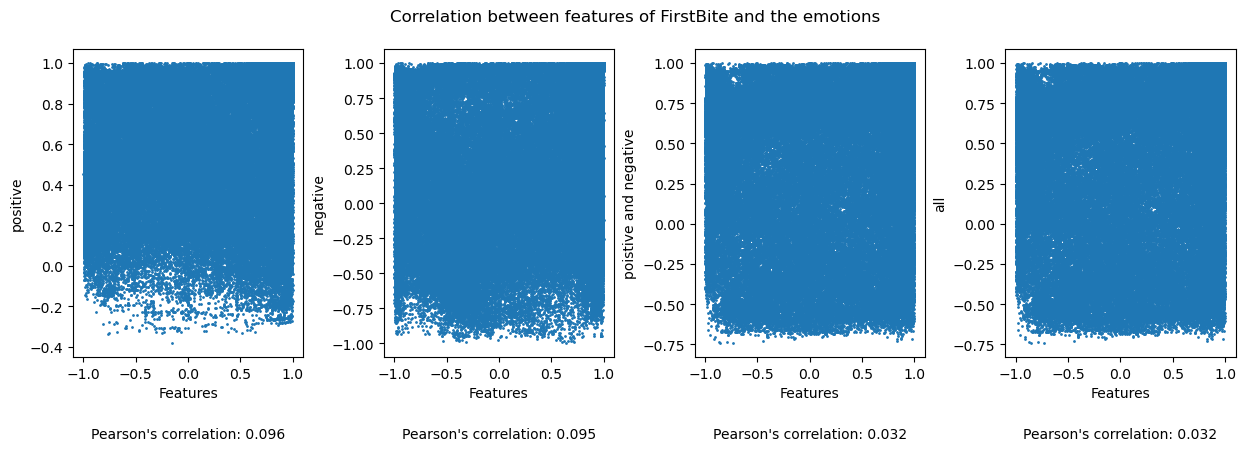

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


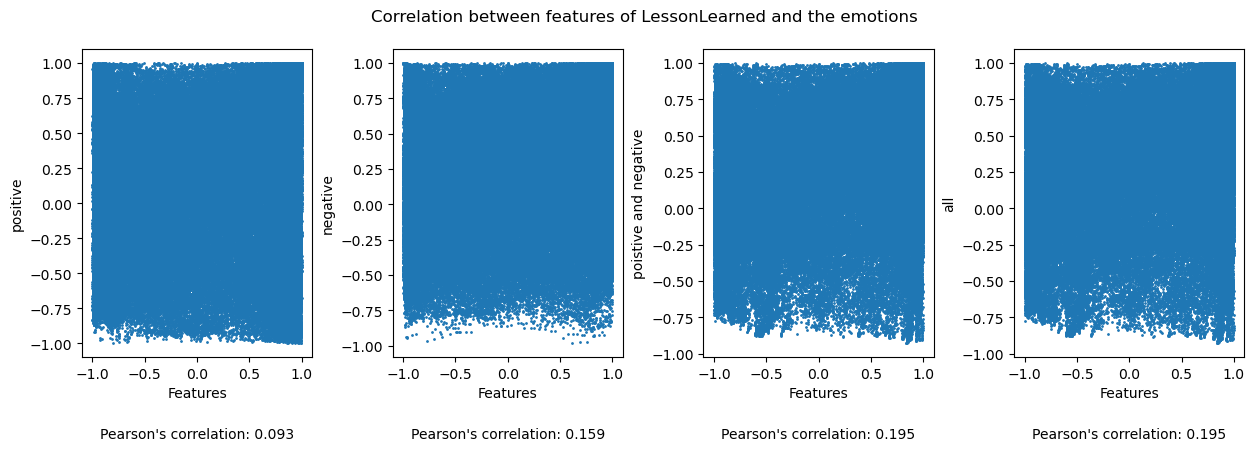

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


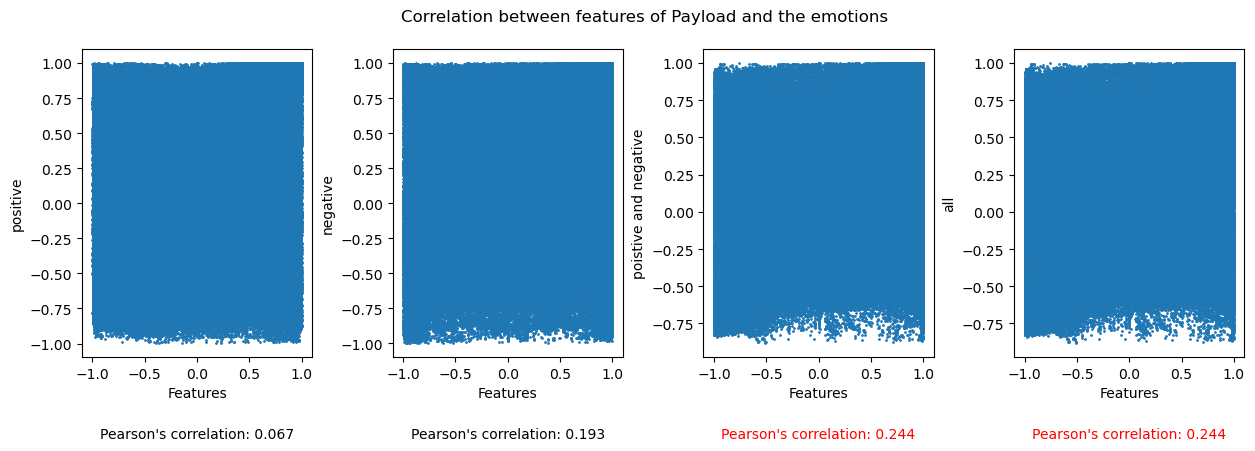

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


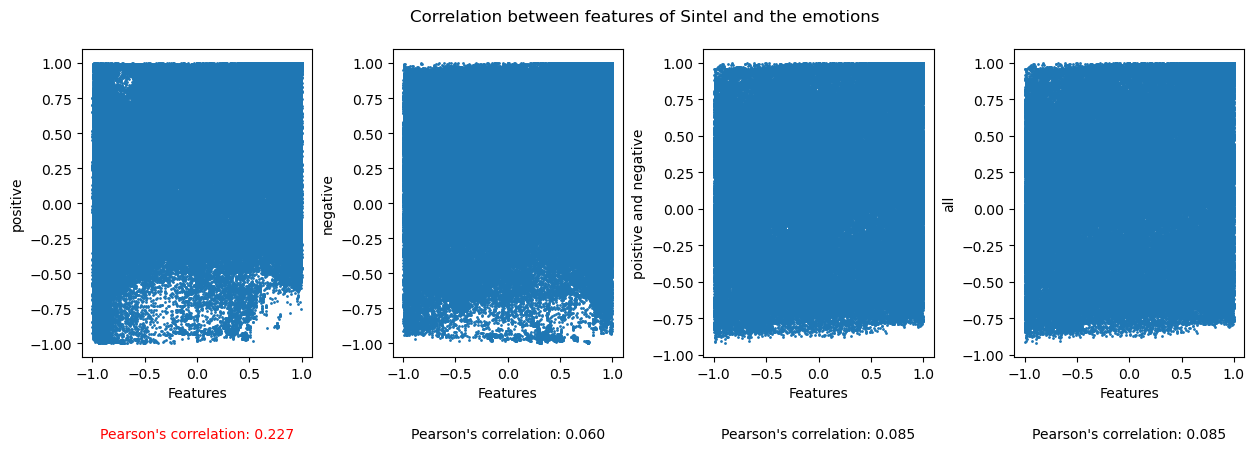

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


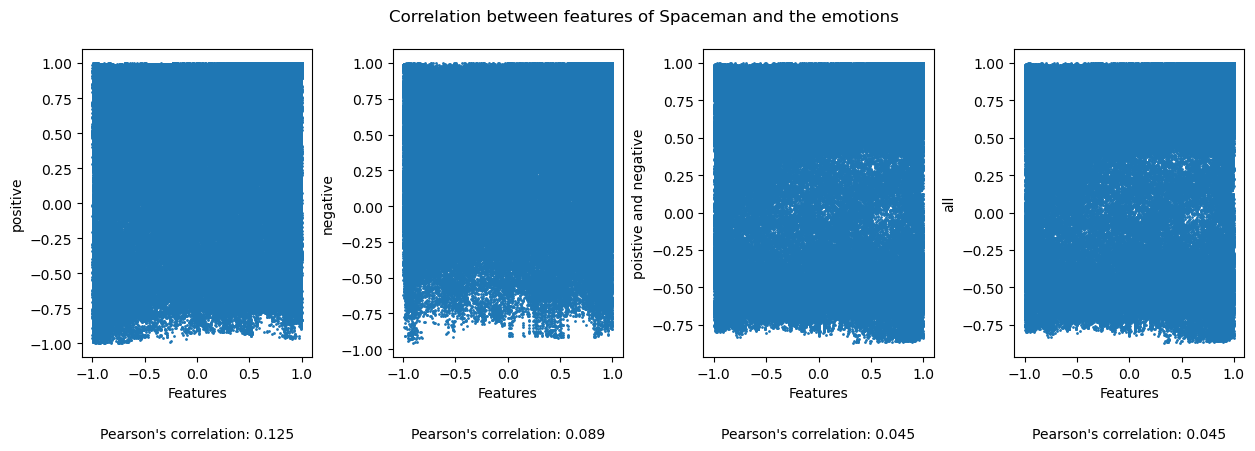

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


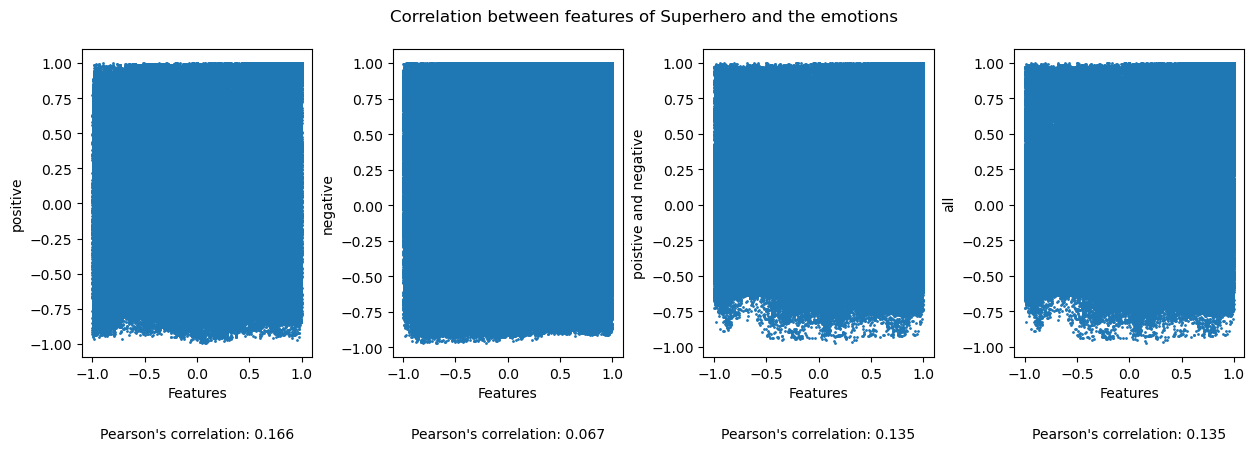

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


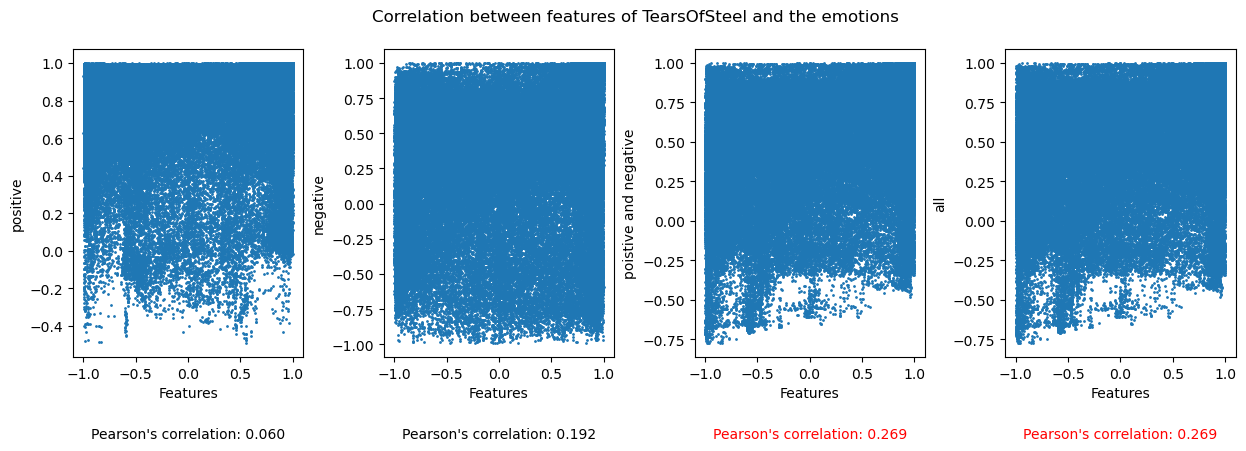

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


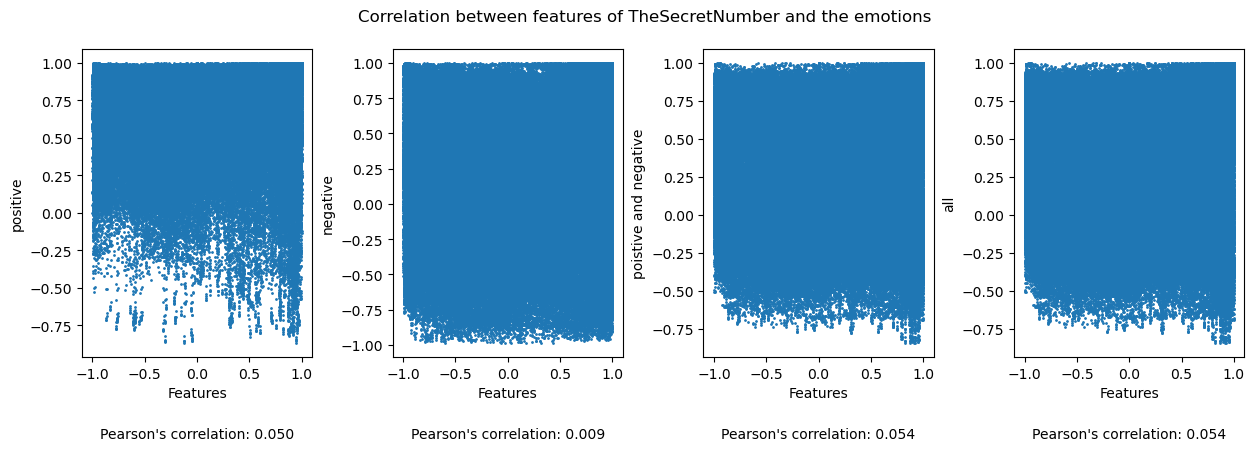

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


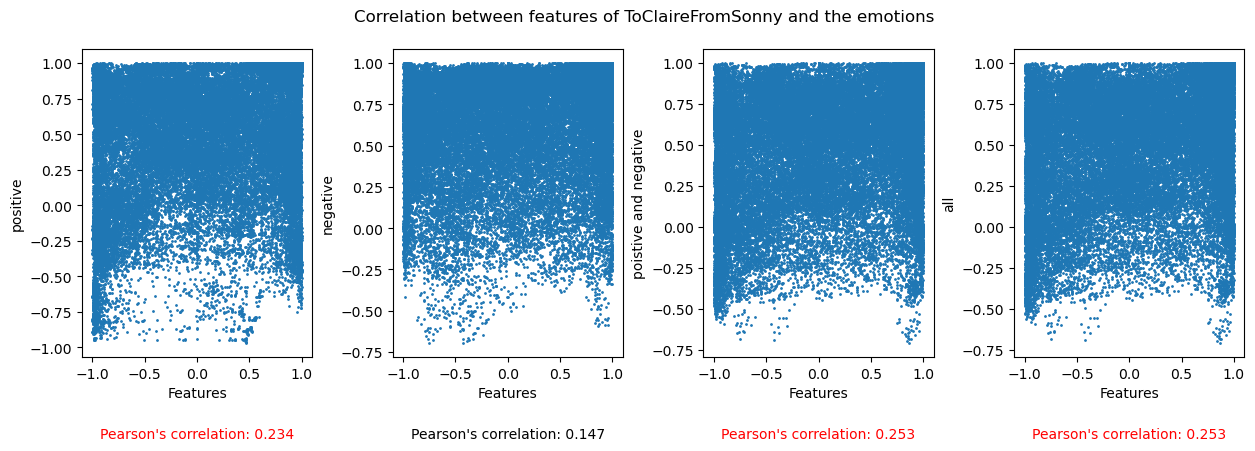

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:2538: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


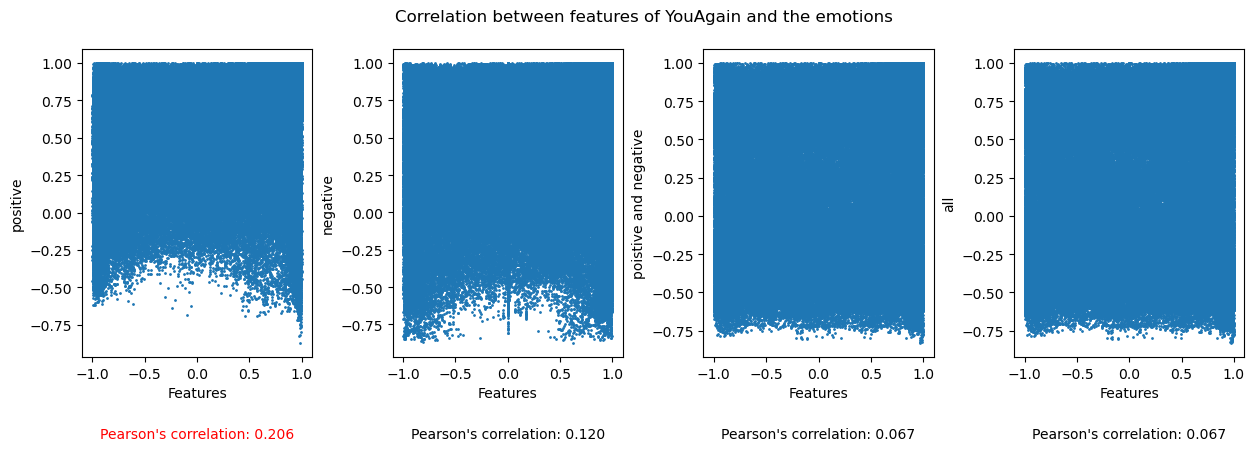

In [95]:
dict_emo = {}
for movie_name in list_movies:
   for i, emotion in enumerate(['positive', 'negative', 'poistive and negative', 'all']):
   

      PATH_EMO = f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/EmoData/'
      emo = extract_corrmat_emo(PATH_EMO, movie_name)
      if emotion == 'all':
         emo = extract_corrmat_allregressors(PATH_EMO, movie_name)
      else:
         all_emo = emo[i]
      dict_emo[movie_name] = all_emo
      length = all_emo.shape[0]
      
      if i == 0:
         ############### IMAGES ################
         df_images = pd.read_csv('/Users/silviaromanato/Downloads/movie_features_Sintel_exp.csv')
         df_sound = pd.read_csv(f'/Users/silviaromanato/Downloads/features_sound_Sintel_exp.csv')

         # mean the columns from mfcc and chromagram
         df_sound['mean_mfcc'] = df_sound[['mfccs_0', 'mfccs_1', 'mfccs_2', 'mfccs_3', 'mfccs_4',
            'mfccs_5', 'mfccs_6', 'mfccs_7', 'mfccs_8', 'mfccs_9', 'mfccs_10',
            'mfccs_11', 'mfccs_12', 'mfccs_13', 'mfccs_14', 'mfccs_15', 'mfccs_16',
            'mfccs_17', 'mfccs_18', 'mfccs_19']].mean(axis=1) 
         df_sound['mean_chroma'] = df_sound[[ 'chromagram_0', 'chromagram_1',
            'chromagram_2', 'chromagram_3', 'chromagram_4', 'chromagram_5',
            'chromagram_6', 'chromagram_7', 'chromagram_8', 'chromagram_9',
            'chromagram_10', 'chromagram_11']].mean(axis=1)
         
         # drop the columns that are not used
         df_sound.drop(columns=['mfccs_0',
            'mfccs_1', 
            'mfccs_2', 'mfccs_3', 'mfccs_4',
            'mfccs_5', 'mfccs_6', 'mfccs_7', 'mfccs_8', 'mfccs_9', 'mfccs_10',
            'mfccs_11', 'mfccs_12', 'mfccs_13', 'mfccs_14', 'mfccs_15', 'mfccs_16',
            'mfccs_17', 'mfccs_18', 'mfccs_19', 
         'chromagram_0', 'chromagram_1',
            'chromagram_2', 'chromagram_3', 'chromagram_4', 'chromagram_5',
            'chromagram_6', 'chromagram_7', 'chromagram_8', 'chromagram_9',
            'chromagram_10', 'chromagram_11',
            'mean_chroma',
            'mean_mfcc',
            #'rms',
            #'zcrs',       
            ], inplace=True)

         features_used = df_sound.columns
         
         window_size1 = df_images.shape[0] // length
         images_mean = np.apply_along_axis(lambda x: np.convolve(x, np.ones(window_size1), mode='valid') / window_size1, axis=0, arr=df_images)

         window_size2 = df_sound.shape[0] // length
         sound_mean = np.apply_along_axis(lambda x: np.convolve(x, np.ones(window_size2), mode='valid') / window_size2, axis=0, arr=df_sound)

         # Select elements to represent the initial arrays
         selected_indices1 = np.linspace(0, len(images_mean) - 1, length, dtype=int)
         selected_indices2 = np.linspace(0, len(sound_mean) - 1, length, dtype=int)
         df_images = pd.DataFrame(images_mean[selected_indices1])
         df_sound = pd.DataFrame(sound_mean[selected_indices2])
         ############### CORRELATION ################
         correlation_features = Correlation_features(None, df_images, movie_name)

      ############### CORRELATION ################
      correlation_features = np.array(correlation_features)
      # replace the nan values with 0
      correlation_features = np.nan_to_num(correlation_features)
      upper_triangle_feat = correlation_features[np.triu_indices_from(correlation_features, k=1)]
      upper_triangle_emo = all_emo[np.triu_indices_from(all_emo, k=1)]


      # compute the correlation
      from scipy.stats import pearsonr
      corr, _ = pearsonr(upper_triangle_feat, upper_triangle_emo)

      ############## PLOT ################

      """# Create a figure with subplots
      fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns of subplots

      # Plot the correlation matrix of features
      sns.heatmap(correlation_features, ax=axes[0])
      axes[0].set_title(f'Correlation matrix of {movie_name} features')
      axes[0].text(0.5, -0.4, f'Features used: all the features from images' + '\n' + f'and from sound {features_used}\nEmotions used: {emotion}',
                  horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)

      # Plot the correlation matrix of emotions
      sns.heatmap(all_emo, ax=axes[1])
      axes[1].set_title(f'Correlation matrix of {movie_name} Emotions')

      # Compute and plot the scatter plot
      corr, _ = pearsonr(upper_triangle_feat, upper_triangle_emo)
      axes[2].scatter(upper_triangle_feat, upper_triangle_emo, s=1)
      axes[2].set_title(f'Scatter plot of {movie_name} features and emotions')
      axes[2].set_xlabel('Features')
      axes[2].set_ylabel('Emotions')
      axes[2].text(0.5, -0.2, f'Pearson\'s correlation: {corr}',
                  horizontalalignment='center', verticalalignment='center', transform=axes[2].transAxes)

      # Adjust layout
      plt.tight_layout()

      # Save or display the figure
      #plt.savefig(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/{movie_name}_plots.png')
      plt.show()"""

      if i == 0:
         fig, axes = plt.subplots(1, 4, figsize=(15, 4))  # 1 row, 3 columns of subplots
      corr, _ = pearsonr(upper_triangle_feat, upper_triangle_emo)
      axes[i].scatter(upper_triangle_feat, upper_triangle_emo, s=1)
      fig.subplots_adjust(wspace=0.35)
      axes[i].set_xlabel('Features')
      axes[i].set_ylabel(f'{emotion}')
      if corr > 0.2:
         axes[i].text(0.5, -0.25, f'Pearson\'s correlation: {corr:.3f}',
                     horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes, color = 'red')
      else: 
         fig.suptitle(f'Correlation between features of {movie_name} and the emotions')
         axes[i].text(0.5, -0.25, f'Pearson\'s correlation: {corr:.3f}',
                     horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
      if i == 3:
         plt.show()
    

## **NOW WITH FMRI DATA**

In [65]:
list_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']

In [101]:

dict_fmri = {}
PATH_DATA = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/FMRI'
for movie_name in list_movies:
   for i, method in enumerate(['bold', 'edges', 'scaffold', 'triangles']):
   

      mtx_tt =pd.read_csv(PATH_DATA + f'/average_{method}/corr_matrix_ave_{method}_{movie_name}.txt', sep=' ', header=None)
      mtx_tt = mtx_tt.fillna(0)
      length = mtx_tt.shape[0]
      
      if i == 0:
         ############### IMAGES ################
         # split the movie name by the capital letter
         text = '_'.join(re.findall(r'[A-Z][a-z]*', movie_name))
         df_images = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/features_extracted/movie_features_{text}_exp.csv')
         df_sound = pd.read_csv(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Data/features_extracted/features_sound_{text}_exp.csv')

         # mean the columns from mfcc and chromagram
         df_sound['mean_mfcc'] = df_sound[['mfccs_0', 'mfccs_1', 'mfccs_2', 'mfccs_3', 'mfccs_4',
            'mfccs_5', 'mfccs_6', 'mfccs_7', 'mfccs_8', 'mfccs_9', 'mfccs_10',
            'mfccs_11', 'mfccs_12', 'mfccs_13', 'mfccs_14', 'mfccs_15', 'mfccs_16',
            'mfccs_17', 'mfccs_18', 'mfccs_19']].mean(axis=1) 
         df_sound['mean_chroma'] = df_sound[[ 'chromagram_0', 'chromagram_1',
            'chromagram_2', 'chromagram_3', 'chromagram_4', 'chromagram_5',
            'chromagram_6', 'chromagram_7', 'chromagram_8', 'chromagram_9',
            'chromagram_10', 'chromagram_11']].mean(axis=1)
         
         # drop the columns that are not used
         df_sound.drop(columns=['mfccs_0',
            'mfccs_1', 
            'mfccs_2', 'mfccs_3', 'mfccs_4',
            'mfccs_5', 'mfccs_6', 'mfccs_7', 'mfccs_8', 'mfccs_9', 'mfccs_10',
            'mfccs_11', 'mfccs_12', 'mfccs_13', 'mfccs_14', 'mfccs_15', 'mfccs_16',
            'mfccs_17', 'mfccs_18', 'mfccs_19', 
         'chromagram_0', 'chromagram_1',
            'chromagram_2', 'chromagram_3', 'chromagram_4', 'chromagram_5',
            'chromagram_6', 'chromagram_7', 'chromagram_8', 'chromagram_9',
            'chromagram_10', 'chromagram_11',
            #'mean_chroma',
            #'mean_mfcc',
            #'rms',
            #'zcrs',       
            ], inplace=True)

         features_used = df_sound.columns
         
         window_size1 = df_images.shape[0] // length
         images_mean = np.apply_along_axis(lambda x: np.convolve(x, np.ones(window_size1), mode='valid') / window_size1, axis=0, arr=df_images)

         window_size2 = df_sound.shape[0] // length
         sound_mean = np.apply_along_axis(lambda x: np.convolve(x, np.ones(window_size2), mode='valid') / window_size2, axis=0, arr=df_sound)

         # Select elements to represent the initial arrays
         selected_indices1 = np.linspace(0, len(images_mean) - 1, length, dtype=int)
         selected_indices2 = np.linspace(0, len(sound_mean) - 1, length, dtype=int)
         df_images = pd.DataFrame(images_mean[selected_indices1])
         df_sound = pd.DataFrame(sound_mean[selected_indices2])
         ############### CORRELATION ################
         correlation_features = Correlation_features(df_sound, df_images, movie_name)

      ############### CORRELATION ################
      mtx_tt = np.array(mtx_tt)
      correlation_features = np.array(correlation_features)
      # replace the nan values with 0
      correlation_features = np.nan_to_num(correlation_features)
      upper_triangle_feat = correlation_features[np.triu_indices_from(correlation_features, k=1)]
      upper_triangle_fmri = mtx_tt[np.triu_indices_from(mtx_tt, k=1)]

      # compute the correlation
      from scipy.stats import pearsonr
      corr, _ = pearsonr(upper_triangle_feat, upper_triangle_fmri)

      ############## PLOT ################

      """# Create a figure with subplots
      fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns of subplots

      # Plot the correlation matrix of features
      sns.heatmap(correlation_features, ax=axes[0])
      axes[0].set_title(f'Correlation matrix of {movie_name} features')
      axes[0].text(0.5, -0.4, f'Features used: all the features from images' + '\n' + f'and from sound {features_used}\Method used: {method}',
                  horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)

      # Plot the correlation matrix of fmri
      sns.heatmap(mtx_tt, ax=axes[1])
      axes[1].set_title(f'Correlation matrix of {movie_name} / {method}')

      # Compute and plot the scatter plot
      corr, _ = pearsonr(upper_triangle_feat, upper_triangle_fmri)
      axes[2].scatter(upper_triangle_feat, upper_triangle_fmri, s=1)
      axes[2].set_title(f'Scatter plot of {movie_name} features and {method}')
      axes[2].set_xlabel('Features')
      axes[2].set_ylabel(f'{method}')
      axes[2].text(0.5, -0.2, f'Pearson\'s correlation: {corr}',
                  horizontalalignment='center', verticalalignment='center', transform=axes[2].transAxes)

      # Adjust layout
      plt.tight_layout()

      # Save or display the figure
      #plt.savefig(f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/{movie_name}_plots.png')
      plt.show()"""
      if i == 0:
         fig, axes = plt.subplots(1, 4, figsize=(15, 4))  # 1 row, 3 columns of subplots
         # pad the subplots' width
         fig.subplots_adjust(wspace=0.35)
      corr, _ = pearsonr(upper_triangle_feat, upper_triangle_fmri)
      axes[i].scatter(upper_triangle_feat, upper_triangle_fmri, s=1)

      if corr > 0.2:
         axes[i].text(0.5, -0.25, f'Pearson\'s correlation: {corr:.3f}',
                  horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes, color='red')
         fig.suptitle(f'Scatter plot of the Correlation between features of {movie_name} and the methods', color = 'red')
         # place the subtitle up
         fig.subplots_adjust(top=0.9)
         axes[i].set_title(f'Features and {method}', color = 'red')
         axes[i].set_xlabel('Features', color = 'red')
         axes[i].set_ylabel(f'{method}', color = 'red')
      else:
         axes[i].text(0.5, -0.25, f'Pearson\'s correlation: {corr:.3f}',
                  horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
         fig.suptitle(f'Scatter plot of the Correlation between features of {movie_name} and the methods')
         axes[i].set_title(f'Features and {method}')
         axes[i].set_xlabel('Features')
         axes[i].set_ylabel(f'{method}')
      if i == 3:
         plt.show()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().